# EDA

### By Grant Lewis


First I load in the data, do some initial exploration and then look at the distribution of the target variable.

In [1]:

import pandas as pd
import os
import numpy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

DATA_PATH = './data/unzipped_data/'

TARGET = 'loan_status'

In [2]:
# Loading and combining Dataframes
dfs = {}

def file_to_datetime(file):
    year = int(file.split('Q')[0])
    quarter = int(file.split('Q')[1])
    month = ((quarter - 1) * 3) + 1
    return pd.to_datetime(f"{year}{month}", format='%Y%m')

for file in os.listdir(DATA_PATH):
    new_df = pd.read_csv(DATA_PATH + file)
    base_file_name = file.split('.')[0]
    
    # file_date used in predicting duration of credit score for both the main borrower and co-borrower
    new_df['file_date'] = file_to_datetime(base_file_name)
    dfs[base_file_name] = new_df

df_all = pd.concat(dfs.values(), ignore_index=True)

#### Adding a file_date column:

I added the file_date column to the data to find the difference between it and other time data, like earliest credit line (earliest_cr_line). Ideallym finding the duration of time instead of a date or year could help us combat against drift in the model. However, experimentation would still have to be performed in order to ensure drift does not occur still.  This was added after analyzing the data.

### Basic Dataframe Information:

I initially wanted to get a feel for the data and see what the basic structure of the dataframe was. I used some basic functions to get some general information on how to move forward.

In [3]:
# Printing some basic information
print('Shape:', df_all.shape)
print('Columns:', df_all.columns)
print('Head:')
df_all.head()

Shape: (438991, 56)
Columns: Index(['id', 'funded_amnt', 'term', 'int_rate', 'installment', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'loan_status', 'purpose',
       'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq',
       'open_acc', 'revol_bal', 'revol_util', 'total_acc', 'application_type',
       'annual_inc_joint', 'dti_joint', 'open_act_il', 'open_il_24m',
       'il_util', 'open_rv_24m', 'all_util', 'total_rev_hi_lim',
       'inq_last_12m', 'acc_open_past_24mths', 'bc_open_to_buy', 'bc_util',
       'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq',
       'mths_since_recent_revol_delinq', 'num_accts_ever_120_pd',
       'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats',
       'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq',
       'percent_bc_gt_75', 'pub_rec_bankruptcies', 'total_bal_ex_mort',
       'total_bc_limit', 'revol_bal_joint', 

,id,funded_amnt,term,int_rate,installment,emp_title,emp_length,home_ownership,annual_inc,loan_status,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,total_bal_ex_mort,total_bc_limit,revol_bal_joint,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,file_date
0,73688651,4000,36 months,11.99%,132.84,Fraud analyst,8 years,RENT,45000.0,Fully Paid,...,100.0,0.0,0,1102,7500,NaN,NaN,NaN,NaN,2016-01-01
1,75678977,7200,36 months,11.47%,237.33,Client Relations Manager,< 1 year,RENT,85000.0,Current,...,90.0,100.0,0,33021,14000,NaN,NaN,NaN,NaN,2016-01-01
2,71905793,20000,36 months,16.29%,706.01,Registerd nurse,8 years,MORTGAGE,56000.0,Current,...,96.6,75.0,2,54298,9700,NaN,NaN,NaN,NaN,2016-01-01
3,74231221,16000,60 months,12.99%,363.97,Financial Advisor,5 years,MORTGAGE,110000.0,Current,...,68.0,87.5,0,45733,39400,NaN,NaN,NaN,NaN,2016-01-01
4,68884968,28000,60 months,15.31%,670.69,Pharmacist-in-Charge,3 years,MORTGAGE,180000.0,Current,...,93.9,100.0,0,273107,51800,NaN,NaN,NaN,NaN,2016-01-01


In [4]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438991 entries, 0 to 438990
Data columns (total 56 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   id                              438991 non-null  int64         
 1   funded_amnt                     438991 non-null  int64         
 2   term                            438991 non-null  object        
 3   int_rate                        438991 non-null  object        
 4   installment                     438991 non-null  float64       
 5   emp_title                       408624 non-null  object        
 6   emp_length                      408978 non-null  object        
 7   home_ownership                  438991 non-null  object        
 8   annual_inc                      438991 non-null  float64       
 9   loan_status                     438991 non-null  object        
 10  purpose                         438991 non-null  object 

In [5]:
df_all.describe()

,id,funded_amnt,installment,annual_inc,dti,delinq_2yrs,fico_range_high,inq_last_6mths,mths_since_last_delinq,open_acc,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,total_bal_ex_mort,total_bc_limit,revol_bal_joint,sec_app_fico_range_high,sec_app_inq_last_6mths
count,4.389910e+05,438991.000000,438991.000000,4.389910e+05,438706.000000,438991.000000,438991.000000,438991.000000,225315.000000,438991.000000,...,438991.000000,438991.000000,438991.000000,433774.000000,438991.000000,4.389910e+05,438991.000000,19670.000000,19671.000000,19671.000000
mean,9.724080e+07,14790.996000,443.451421,7.978605e+04,19.053124,0.343415,701.844279,0.533523,33.849042,11.746391,...,0.090811,2.130048,93.669153,40.881013,0.139611,5.235281e+04,23299.998446,31507.813523,669.674902,0.675258
std,1.762117e+07,9323.740928,277.262393,8.194272e+04,14.427149,0.930063,32.929589,0.830201,21.887352,5.767707,...,0.537118,1.884543,9.456735,36.189174,0.384764,5.106754e+04,23030.807798,25024.701622,44.342382,1.033539
min,5.571600e+04,1000.000000,6.680000,0.000000e+00,-1.000000,0.000000,664.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,544.000000,0.000000
25%,8.151795e+07,7500.000000,241.130000,4.759490e+04,12.130000,0.000000,674.000000,0.000000,15.000000,8.000000,...,0.000000,1.000000,90.600000,0.000000,0.000000,2.138700e+04,8400.000000,14413.000000,644.000000,0.000000
50%,9.617448e+07,12000.000000,370.910000,6.626400e+04,18.100000,0.000000,694.000000,0.000000,30.000000,11.000000,...,0.000000,2.000000,97.600000,33.300000,0.000000,3.874100e+04,16400.000000,25186.000000,669.000000,0.000000
75%,1.130768e+08,20000.000000,593.490000,9.500000e+04,24.800000,0.000000,719.000000,1.000000,49.000000,15.000000,...,0.000000,3.000000,100.000000,66.700000,0.000000,6.611400e+04,30400.000000,41353.750000,694.000000,1.000000
max,1.264193e+08,40000.000000,1719.830000,1.099920e+07,999.000000,42.000000,850.000000,5.000000,195.000000,97.000000,...,42.000000,29.000000,100.000000,100.000000,8.000000,3.408095e+06,719500.000000,304206.000000,850.000000,6.000000


Based on the distributions of values, there are several potential outliers in the data. This is not that surprising for some fields, like months since last delinquency. In most cases, these are probably legitimate values. However it is important to concider when thinking about the data.

In [6]:
df_all.describe(include=['O'])

,term,int_rate,emp_title,emp_length,home_ownership,loan_status,purpose,zip_code,addr_state,earliest_cr_line,revol_util,application_type,sec_app_earliest_cr_line
count,438991,438991,408624,408978,438991,438991,438991,438991,438991,438991,438632,438991,19671
unique,2,169,120032,11,5,6,14,908,50,680,1163,2,559
top,36 months,5.32%,Teacher,10+ years,MORTGAGE,Current,debt_consolidation,750xx,CA,Sep-05,0%,Individual,Aug-06
freq,322236,17480,8392,148471,214298,251552,246935,4620,58548,3353,2235,413182,191


Analyzing the Distribution of the Target Variable (loan_status)


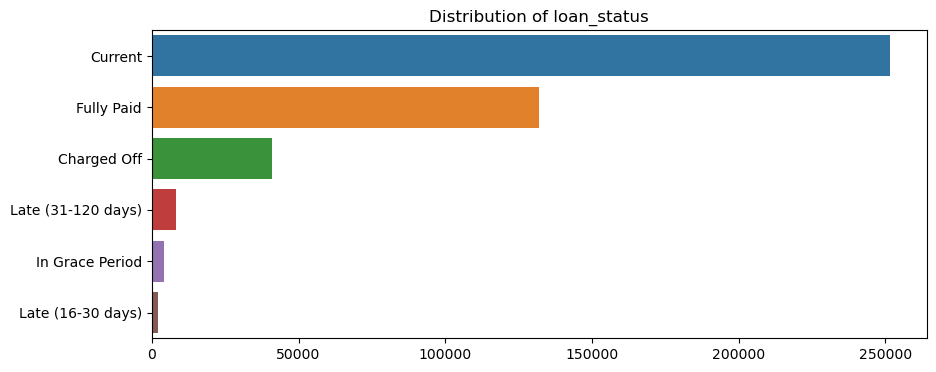

In [64]:
print(f'Analyzing the Distribution of the Target Variable ({TARGET})')
plt.figure(figsize=(10, 4))
vals = df_all[TARGET].value_counts().to_dict()
# print(vals)
# sns.countplot(y=column, data=df_all)
# sns.barplot(x=vals, y=list(vals.keys()).sort())
sns.barplot(x=list(vals.values()), y=list(vals.keys()))
plt.title(f'Distribution of {TARGET}')
plt.show()

Based on the above results, I may need to undersample/downsample the number of samples for each desired variable class. If we don't, there is a very good chance a model would gain a bias towards predicting the majoirty class.

The goal is to know which loans on the site are the best to invest in.  Ideally, we would want a high level of confidence that the loan will be paid off in full by the end of the loan. There are several ways we could approach this problem given the provided data.  We could train a model on only fully paid and charged off loans.  However, this does not involve the majority of the data. We could also train a model on all of the loan statuses, but this could lead to a lower accuracy.  We could also train a binary classifier that predicts if a model is fully paid off or not.  This would allow for more data to be included. Ultimately, we would still have to undersample the data to ensure that the model does not become overly biased. My initial guess is that a binary classifier, where we predict if a loan is fully paid off or not, would be the best approach. However, I will try several of the methods to see which one works best.


### Exploring values of object/string columns

In [65]:
object_columns = df_all.select_dtypes(include=['O']).columns
print(object_columns)
for col in object_columns:
    print(col, df_all[col].unique())

Index(['term', 'int_rate', 'emp_title', 'emp_length', 'home_ownership',
       'loan_status', 'purpose', 'zip_code', 'addr_state', 'earliest_cr_line',
       'revol_util', 'application_type', 'sec_app_earliest_cr_line'],
      dtype='object')
term [' 36 months' ' 60 months']
int_rate ['11.99%' '11.47%' '16.29%' '12.99%' '15.31%' '13.67%' '14.46%' '18.49%'
 '19.99%' '10.75%' '8.39%' '5.32%' '7.39%' '24.99%' '9.75%' '7.89%'
 '8.49%' '25.88%' '10.78%' '6.99%' '18.25%' '21.18%' '19.53%' '20.75%'
 '21.48%' '14.85%' '6.49%' '9.16%' '6.97%' '18.99%' '13.44%' '15.77%'
 '9.76%' '13.99%' '9.80%' '12.88%' '22.45%' '7.49%' '11.48%' '17.97%'
 '19.89%' '7.91%' '17.27%' '20.50%' '21.97%' '9.17%' '23.13%' '26.57%'
 '27.34%' '12.59%' '16.59%' '26.06%' '24.11%' '19.48%' '28.99%' '6.00%'
 '24.24%' '28.14%' '25.09%' '7.26%' '17.57%' '13.18%' '28.67%' '16.99%'
 '25.99%' '10.64%' '28.34%' '28.49%' '8.38%' '27.49%' '15.41%' '27.99%'
 '20.99%' '26.99%' '11.22%' '14.48%' '6.89%' '21.99%' '6.24%' '16.55%'
 '17.

### Normalizing String Values


In [66]:
def term_to_num(str_val):
    number, unit = str_val.strip().split(' ')
    if unit == 'months':
        return int(number)
    # In case data is not normalized in the future
    elif unit == 'years': 
        return int(number) * 12
    else:
        raise ValueError(f'Unknown unit {unit}')

def percent_to_num(str_val):
    if isinstance(str_val, float):
        return str_val
    return float(str_val.strip().strip('%')) / 100

def emp_length_to_bin(str_val):
    if pd.isnull(str_val):
        return str_val
    if str_val.startswith('<'):
        return 0
    if str_val.startswith('10'):
        return 10
    return int(str_val.split(' ')[0])



df_cleaned = df_all.copy()

df_cleaned.drop('id', axis=1, inplace=True)

df_cleaned['term'] = df_cleaned['term'].apply(term_to_num)

df_cleaned['int_rate'] = df_cleaned['int_rate'].apply(percent_to_num)
df_cleaned['revol_util'] = df_cleaned['revol_util'].apply(percent_to_num)

df_cleaned['emp_length'] = df_cleaned['emp_length'].apply(emp_length_to_bin)

df_cleaned['zip_3'] = df_cleaned['zip_code'].apply(lambda x: int(x[:3]))
df_cleaned.drop('zip_code', axis=1, inplace=True)

# This is probably the biggest change made to the data. We are converting the earliest credit line to the number of months since the file date which allows us to use it as a numerical feature
# Convert date columns to datetime then finding the difference in months from file_date
month_year_columns = ['earliest_cr_line', 'sec_app_earliest_cr_line']
for col in month_year_columns:
    df_cleaned[col] = pd.to_datetime(df_cleaned[col], format='%b-%y')
    
    # Calculate the delta in months. (using 30 days per month)
    df_cleaned[col] = (df_cleaned['file_date'] - df_cleaned[col]).dt.days / 30

df_cleaned['application_type'] = df_cleaned['application_type'].apply(lambda x: 0 if x == 'Individual' else 1)

df_cleaned.drop(['emp_title'], axis=1, inplace=True)


# Numbers chosen to signify varying levels of risk
TARGET_DICT = {'Fully Paid' : 2,
                'Current': 1,
                'In Grace Period': 0,
                'Late (16-30 days)': -1,
                'Late (31-120 days)': -2,
                'Charged Off': -3,
               }

df_cleaned[TARGET] = df_cleaned[TARGET].apply(lambda x: TARGET_DICT[x])

object_columns = df_cleaned.select_dtypes(include=['O']).columns
# Printing Remaining Object Columns and their unique values to verify they would be acceptable as dummy variables
print(object_columns)
for col in object_columns:
    print(col, len(df_cleaned[col].unique()), df_cleaned[col].unique())
    
# Dropping "file_source" column as it is not useful for us in this case
df_cleaned.drop('file_date', axis=1, inplace=True)
# object_columns = object_columns.drop('file_date')

# Converting remaining object/string columns to dummy variables
df_cleaned_with_dummies = pd.get_dummies(df_cleaned, columns=object_columns)

new_order = [val for val in df_cleaned.columns if  val != TARGET]
new_order.append(TARGET)
# print(new_order)
df_cleaned = df_cleaned[new_order] 



Index(['home_ownership', 'purpose', 'addr_state'], dtype='object')
home_ownership 5 ['RENT' 'MORTGAGE' 'OWN' 'ANY' 'NONE']
purpose 14 ['debt_consolidation' 'home_improvement' 'credit_card' 'other'
 'small_business' 'car' 'vacation' 'major_purchase' 'house' 'medical'
 'moving' 'renewable_energy' 'wedding' 'educational']
addr_state 50 ['AZ' 'OR' 'FL' 'IL' 'TN' 'CO' 'ID' 'MD' 'WA' 'PA' 'CA' 'TX' 'LA' 'CT'
 'GA' 'SC' 'NY' 'MA' 'IN' 'AL' 'MN' 'DC' 'NJ' 'NM' 'OH' 'WV' 'VA' 'NC'
 'UT' 'NV' 'MI' 'WI' 'VT' 'AK' 'HI' 'ND' 'KY' 'NE' 'MO' 'KS' 'OK' 'MS'
 'ME' 'RI' 'WY' 'AR' 'DE' 'MT' 'NH' 'SD']


In [67]:
df_cleaned[month_year_columns].head()

,earliest_cr_line,sec_app_earliest_cr_line
0,42.633333,NaN
1,144.100000,NaN
2,129.900000,NaN
3,333.800000,NaN
4,212.066667,NaN


In [68]:
df_cleaned.to_csv('data/normalized.csv', index=False)

df_cleaned_with_dummies.to_csv('data/normalized_with_dummies.csv', index=False)

df_cleaned_with_dummies.dropna().to_csv('data/normalized_with_dummies_no_na.csv', index=False)


### Analyzing Correlations

In [69]:
correlation_matrix = df_cleaned.corr()
# Extract correlations with the target variable
target_correlation = correlation_matrix[TARGET].sort_values(ascending=False, key=abs)

# remove the target correlation with itself
target_correlation = target_correlation[1:]


target_corr = pd.DataFrame({'Correlation': target_correlation.values, 'Normalized_Correlation': target_correlation.abs() / target_correlation.abs().sum()})
# target_corr['Normalized'] = target_correlation.abs() / target_correlation.abs().sum()

# normalize the correlation by the maximum value
# target_correlation = target_correlation / target_correlation.abs().sum() # max()

print('Normalized Correlation to Target:')
print(target_corr)

C:\Users\grant\AppData\Local\Temp\ipykernel_17928\2043556327.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df_cleaned.corr()


Normalized Correlation to Target:
                                Correlation  Normalized_Correlation
int_rate                          -0.195731                0.089281
sec_app_fico_range_high            0.142782                0.065128
fico_range_high                    0.106963                0.048790
sec_app_inq_last_6mths            -0.094585                0.043144
dti_joint                         -0.087481                0.039903
term                              -0.075931                0.034635
bc_open_to_buy                     0.070909                0.032344
all_util                          -0.068361                0.031182
mort_acc                           0.067385                0.030737
bc_util                           -0.066542                0.030352
open_rv_24m                       -0.064302                0.029331
acc_open_past_24mths              -0.064199                0.029284
percent_bc_gt_75                  -0.063830                0.029115
revol_util    

C:\Users\grant\AppData\Local\Temp\ipykernel_17928\2424281461.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_cleaned.corr(), cmap='coolwarm') # annot=True, fmt=".2f"


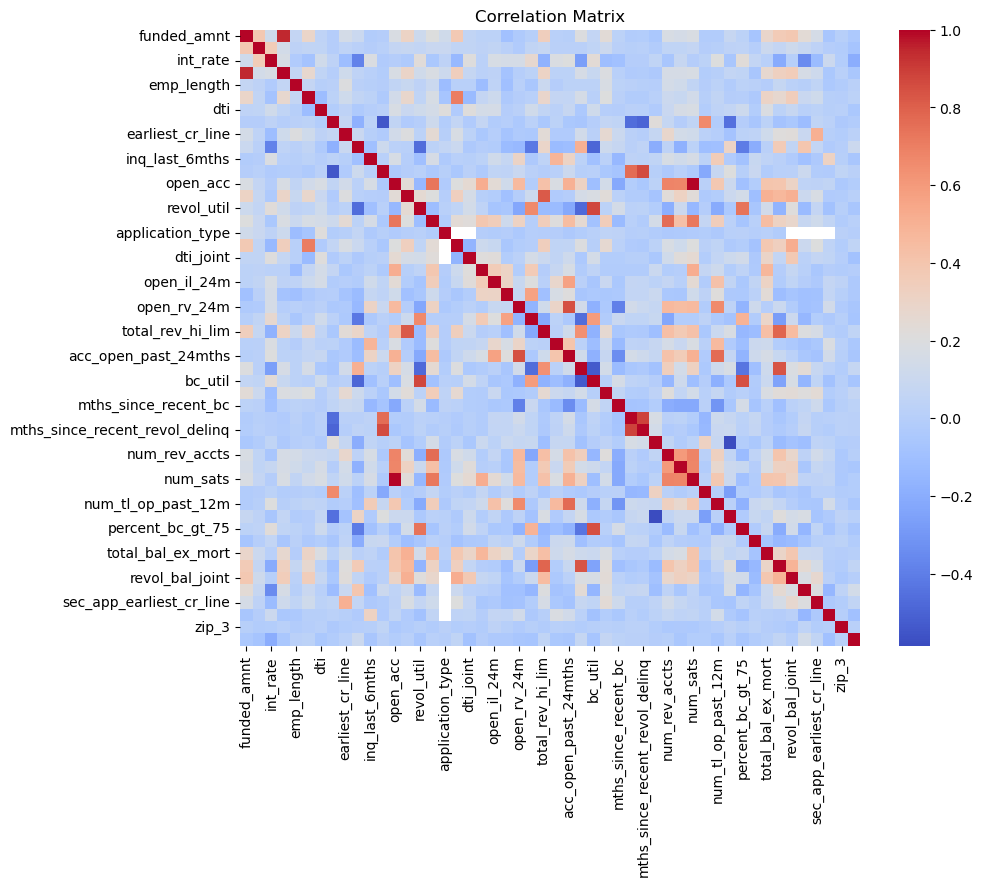

In [70]:
# Heatmap of correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df_cleaned.corr(), cmap='coolwarm') # annot=True, fmt=".2f"
plt.title('Correlation Matrix')
plt.show()

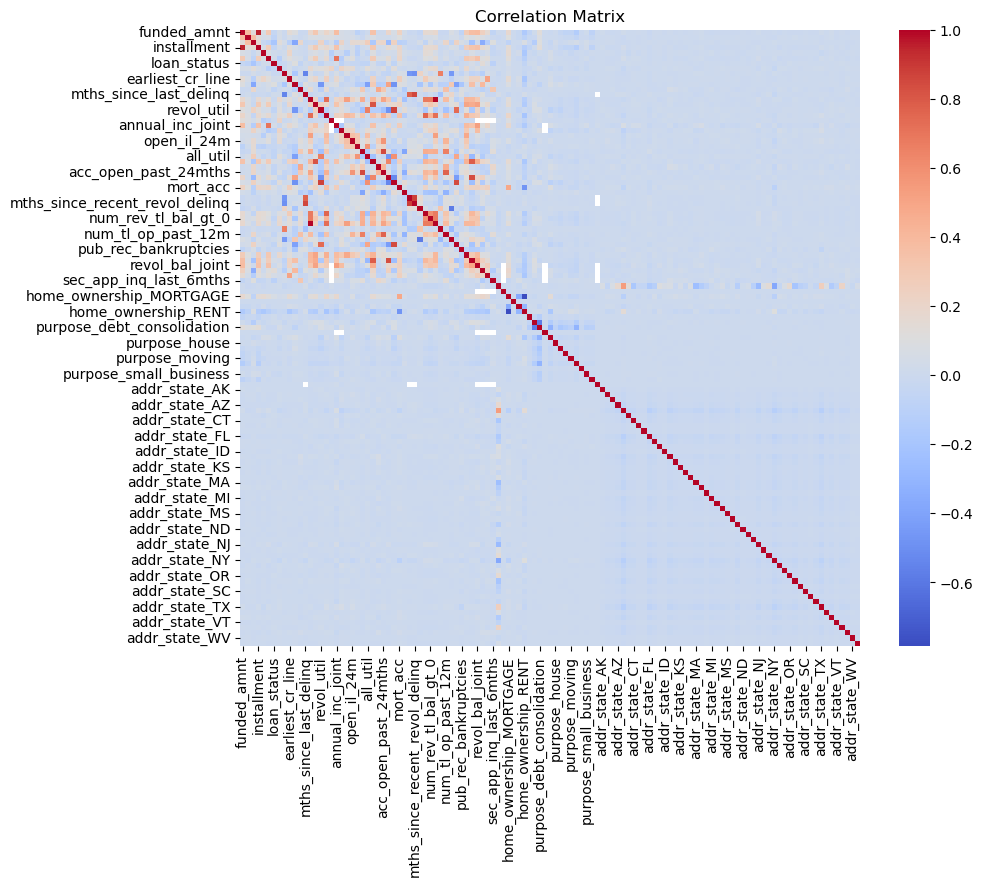

In [71]:
# Heatmap of correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df_cleaned_with_dummies.corr(), cmap='coolwarm') # annot=True, fmt=".2f"
plt.title('Correlation Matrix')
plt.show()

### Other Plots

These were commented out since they were not used in the final analysis.

In [8]:
# # Histograms for numerical features
# num_features = df_cleaned.select_dtypes(include=['int64', 'float64']).columns
# for column in num_features:
#     plt.figure(figsize=(10, 4))
#     sns.histplot(df_cleaned[column], kde=True)
#     plt.title(f'Distribution of {column}')
#     plt.show()

In [7]:
## Plot the counts for Categorical Data

# for column in object_columns:
#     plt.figure(figsize=(10, 4))
#     vals = df_all[column].value_counts().to_dict()

#     sns.barplot(x=list(vals.values()), y=list(vals.keys()))
#     plt.title(f'Distribution of {column}')
#     plt.show()

NameError: name 'object_columns' is not defined

### Takeaways from EDA

In hindesight, I would have liked to spend more time working on feature selection and reducing the number of features being passed into the models.  This would have likely imporved the results of the models I trained. 